In [1]:
# Betting Odds Accuracy Evaluation - Comparing Different Bookmakers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned match data
match_df = pd.read_csv('../data/cleaned/match_df_cleaned.csv')

print("Dataset Information:")
print(f"Total matches: {len(match_df)}")
print(f"Date range: {match_df['date'].min()} to {match_df['date'].max()}")

# Create winner column
def determine_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'home'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'away'
    else:
        return 'draw'

match_df['winner'] = match_df.apply(determine_winner, axis=1)

print("\nMatch outcomes distribution:")
print(match_df['winner'].value_counts())
print(match_df['winner'].value_counts(normalize=True))

Dataset Information:
Total matches: 8045
Date range: 2008-08-15 00:00:00 to 2016-05-17 00:00:00

Match outcomes distribution:
winner
home    3740
away    2327
draw    1978
Name: count, dtype: int64
winner
home    0.464885
away    0.289248
draw    0.245867
Name: proportion, dtype: float64


In [2]:
# Define bookmakers and their odds columns
bookmakers = {
    'Bet365': {'home': 'B365H', 'draw': 'B365D', 'away': 'B365A'},
    'Bwin': {'home': 'BWH', 'draw': 'BWD', 'away': 'BWA'},
    'Interwetten': {'home': 'IWH', 'draw': 'IWD', 'away': 'IWA'},
    'Ladbrokes': {'home': 'LBH', 'draw': 'LBD', 'away': 'LBA'},
    'William Hill': {'home': 'WHH', 'draw': 'WHD', 'away': 'WHA'},
    'Stan James': {'home': 'SJH', 'draw': 'SJD', 'away': 'SJA'},
    'VC Bet': {'home': 'VCH', 'draw': 'VCD', 'away': 'VCA'},
    'Gamebookers': {'home': 'GBH', 'draw': 'GBD', 'away': 'GBA'},
    'Blue Square': {'home': 'BSH', 'draw': 'BSD', 'away': 'BSA'},
    'Median': {'home': 'betting_median_home', 'draw': 'betting_median_draw', 'away': 'betting_median_away'}
}

# Check data availability for each bookmaker
print("Data Availability Analysis:")
print("=" * 60)

coverage_stats = {}
for bookie_name, cols in bookmakers.items():
    home_col, draw_col, away_col = cols['home'], cols['draw'], cols['away']
    
    if all(col in match_df.columns for col in [home_col, draw_col, away_col]):
        # Count non-null values for all three outcomes
        non_null_count = match_df[[home_col, draw_col, away_col]].dropna().shape[0]
        coverage_pct = (non_null_count / len(match_df)) * 100
        
        coverage_stats[bookie_name] = {
            'matches': non_null_count,
            'coverage': coverage_pct,
            'columns': [home_col, draw_col, away_col]
        }
        
        print(f"{bookie_name:15}: {non_null_count:4d} matches ({coverage_pct:5.1f}% coverage)")
    else:
        print(f"{bookie_name:15}: Missing columns")

print(f"\nBookmakers with >50% coverage:")
quality_bookies = {k: v for k, v in coverage_stats.items() if v['coverage'] > 50}
for name, stats in quality_bookies.items():
    print(f"  • {name}: {stats['matches']} matches")

Data Availability Analysis:
Bet365         : 8043 matches (100.0% coverage)
Bwin           : 8042 matches (100.0% coverage)
Interwetten    : 8034 matches ( 99.9% coverage)
Ladbrokes      : 8041 matches (100.0% coverage)
William Hill   : 8043 matches (100.0% coverage)
Stan James     : 6061 matches ( 75.3% coverage)
VC Bet         : 8042 matches (100.0% coverage)
Gamebookers    : 4904 matches ( 61.0% coverage)
Blue Square    : 4910 matches ( 61.0% coverage)
Median         : 8043 matches (100.0% coverage)

Bookmakers with >50% coverage:
  • Bet365: 8043 matches
  • Bwin: 8042 matches
  • Interwetten: 8034 matches
  • Ladbrokes: 8041 matches
  • William Hill: 8043 matches
  • Stan James: 6061 matches
  • VC Bet: 8042 matches
  • Gamebookers: 4904 matches
  • Blue Square: 4910 matches
  • Median: 8043 matches


In [3]:
# Function to convert odds to probabilities and evaluate accuracy
def evaluate_bookmaker_accuracy(df, bookie_name, odds_cols):
    """
    Evaluate how accurate a bookmaker's odds are at predicting outcomes
    """
    home_col, draw_col, away_col = odds_cols['home'], odds_cols['draw'], odds_cols['away']
    
    # Filter data with complete odds
    bookie_data = df[[home_col, draw_col, away_col, 'winner']].dropna().copy()
    
    if len(bookie_data) == 0:
        return None
    
    # Convert odds to probabilities
    bookie_data['prob_home'] = 1 / bookie_data[home_col]
    bookie_data['prob_draw'] = 1 / bookie_data[draw_col]
    bookie_data['prob_away'] = 1 / bookie_data[away_col]
    
    # Normalize probabilities (remove bookmaker margin)
    prob_sum = bookie_data['prob_home'] + bookie_data['prob_draw'] + bookie_data['prob_away']
    bookie_data['prob_home_norm'] = bookie_data['prob_home'] / prob_sum
    bookie_data['prob_draw_norm'] = bookie_data['prob_draw'] / prob_sum
    bookie_data['prob_away_norm'] = bookie_data['prob_away'] / prob_sum
    
    # Calculate bookmaker margin
    avg_margin = (prob_sum.mean() - 1) * 100
    
    # Get predictions (highest probability outcome)
    prob_cols = ['prob_home_norm', 'prob_draw_norm', 'prob_away_norm']
    outcome_map = {0: 'home', 1: 'draw', 2: 'away'}
    bookie_data['predicted'] = bookie_data[prob_cols].values.argmax(axis=1)
    bookie_data['predicted'] = bookie_data['predicted'].map(outcome_map)
    
    # Calculate accuracy
    accuracy = accuracy_score(bookie_data['winner'], bookie_data['predicted'])
    
    # Calculate Brier Score (lower is better)
    y_true_encoded = pd.get_dummies(bookie_data['winner'])[['away', 'draw', 'home']].values
    y_prob = bookie_data[['prob_away_norm', 'prob_draw_norm', 'prob_home_norm']].values
    brier_score = brier_score_loss(y_true_encoded.ravel(), y_prob.ravel())
    
    # Calculate log loss (lower is better)
    log_loss_score = log_loss(bookie_data['winner'], y_prob, labels=['away', 'draw', 'home'])
    
    return {
        'bookmaker': bookie_name,
        'matches': len(bookie_data),
        'accuracy': accuracy,
        'brier_score': brier_score,
        'log_loss': log_loss_score,
        'avg_margin': avg_margin,
        'data': bookie_data
    }

# Evaluate all bookmakers
print("Evaluating Bookmaker Accuracy...")
print("=" * 60)

results = []
detailed_results = {}

for bookie_name, odds_cols in quality_bookies.items():
    result = evaluate_bookmaker_accuracy(match_df, bookie_name, bookmakers[bookie_name])
    if result:
        results.append(result)
        detailed_results[bookie_name] = result
        print(f"{bookie_name:15}: {result['accuracy']:.4f} accuracy, {result['brier_score']:.4f} Brier, {result['avg_margin']:.2f}% margin")

# Create summary DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('accuracy', ascending=False)

print(f"\nSummary of Bookmaker Performance:")
print(results_df[['bookmaker', 'matches', 'accuracy', 'brier_score', 'log_loss', 'avg_margin']].round(4))

Evaluating Bookmaker Accuracy...
Bet365         : 0.5361 accuracy, 0.1920 Brier, 5.43% margin
Bwin           : 0.5357 accuracy, 0.1922 Brier, 7.18% margin
Interwetten    : 0.5367 accuracy, 0.1925 Brier, 8.89% margin
Ladbrokes      : 0.5365 accuracy, 0.1922 Brier, 7.31% margin
William Hill   : 0.5348 accuracy, 0.1922 Brier, 7.04% margin
Stan James     : 0.5339 accuracy, 0.1924 Brier, 6.01% margin
VC Bet         : 0.5341 accuracy, 0.1920 Brier, 4.29% margin
Gamebookers    : 0.5320 accuracy, 0.1937 Brier, 7.42% margin
Blue Square    : 0.5318 accuracy, 0.1936 Brier, 7.41% margin
Median         : 0.5345 accuracy, 0.1920 Brier, 6.34% margin

Summary of Bookmaker Performance:
      bookmaker  matches  accuracy  brier_score  log_loss  avg_margin
2   Interwetten     8034    0.5367       0.1925    0.9721      8.8948
3     Ladbrokes     8041    0.5365       0.1922    0.9707      7.3055
0        Bet365     8043    0.5361       0.1920    0.9695      5.4342
1          Bwin     8042    0.5357       0

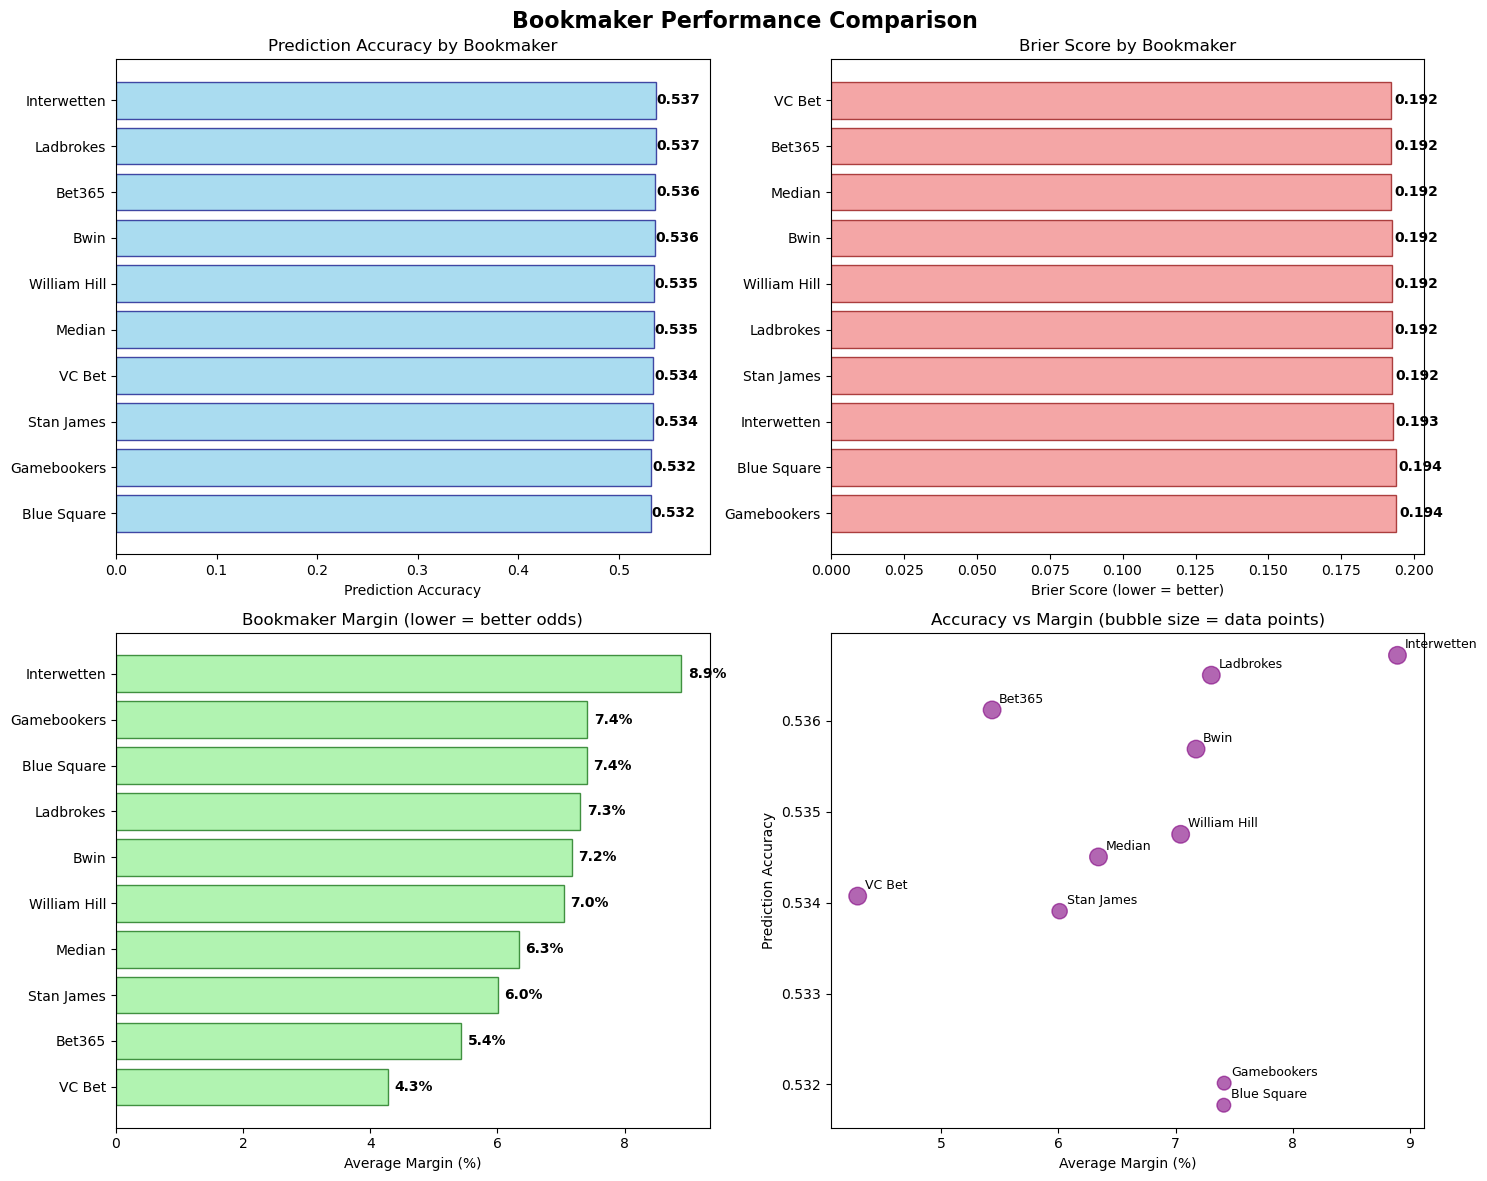


DETAILED BOOKMAKER ANALYSIS

🏆 BEST ACCURACY: Interwetten
   Accuracy: 0.5367 (53.67%)
   Brier Score: 0.1925
   Margin: 8.89%

📊 BEST CALIBRATION (Lowest Brier Score): VC Bet
   Brier Score: 0.1920
   Accuracy: 0.5341

💰 BEST VALUE (Lowest Margin): VC Bet
   Margin: 4.29%
   Accuracy: 0.5341

📈 BASELINE COMPARISON:
   Random guessing accuracy: ~33.3% (3 outcomes)
   Always pick home accuracy: 46.5%
   Best bookmaker beats random by: 20.4 percentage points


In [4]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bookmaker Performance Comparison', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
ax1 = axes[0, 0]
accuracy_data = results_df.sort_values('accuracy', ascending=True)
bars1 = ax1.barh(accuracy_data['bookmaker'], accuracy_data['accuracy'], 
                color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('Prediction Accuracy')
ax1.set_title('Prediction Accuracy by Bookmaker')
ax1.set_xlim(0, max(accuracy_data['accuracy']) * 1.1)

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

# 2. Brier Score Comparison (lower is better)
ax2 = axes[0, 1]
brier_data = results_df.sort_values('brier_score', ascending=False)
bars2 = ax2.barh(brier_data['bookmaker'], brier_data['brier_score'], 
                color='lightcoral', edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Brier Score (lower = better)')
ax2.set_title('Brier Score by Bookmaker')

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

# 3. Bookmaker Margin
ax3 = axes[1, 0]
margin_data = results_df.sort_values('avg_margin', ascending=True)
bars3 = ax3.barh(margin_data['bookmaker'], margin_data['avg_margin'], 
                color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax3.set_xlabel('Average Margin (%)')
ax3.set_title('Bookmaker Margin (lower = better odds)')

# Add value labels
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center', fontweight='bold')

# 4. Accuracy vs Margin Scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['avg_margin'], results_df['accuracy'], 
                     s=results_df['matches']/50, alpha=0.6, c='purple')
ax4.set_xlabel('Average Margin (%)')
ax4.set_ylabel('Prediction Accuracy')
ax4.set_title('Accuracy vs Margin (bubble size = data points)')

# Add bookmaker labels
for _, row in results_df.iterrows():
    ax4.annotate(row['bookmaker'], (row['avg_margin'], row['accuracy']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("DETAILED BOOKMAKER ANALYSIS")
print("="*80)

best_accuracy = results_df.iloc[0]
worst_accuracy = results_df.iloc[-1]
best_brier = results_df.loc[results_df['brier_score'].idxmin()]
lowest_margin = results_df.loc[results_df['avg_margin'].idxmin()]

print(f"\n🏆 BEST ACCURACY: {best_accuracy['bookmaker']}")
print(f"   Accuracy: {best_accuracy['accuracy']:.4f} ({best_accuracy['accuracy']*100:.2f}%)")
print(f"   Brier Score: {best_accuracy['brier_score']:.4f}")
print(f"   Margin: {best_accuracy['avg_margin']:.2f}%")

print(f"\n📊 BEST CALIBRATION (Lowest Brier Score): {best_brier['bookmaker']}")
print(f"   Brier Score: {best_brier['brier_score']:.4f}")
print(f"   Accuracy: {best_brier['accuracy']:.4f}")

print(f"\n💰 BEST VALUE (Lowest Margin): {lowest_margin['bookmaker']}")
print(f"   Margin: {lowest_margin['avg_margin']:.2f}%")
print(f"   Accuracy: {lowest_margin['accuracy']:.4f}")

print(f"\n📈 BASELINE COMPARISON:")
print(f"   Random guessing accuracy: ~33.3% (3 outcomes)")
print(f"   Always pick home accuracy: {(match_df['winner'] == 'home').mean()*100:.1f}%")
print(f"   Best bookmaker beats random by: {(best_accuracy['accuracy'] - 0.333)*100:.1f} percentage points")

Calibration Analysis for Top 3 Bookmakers:


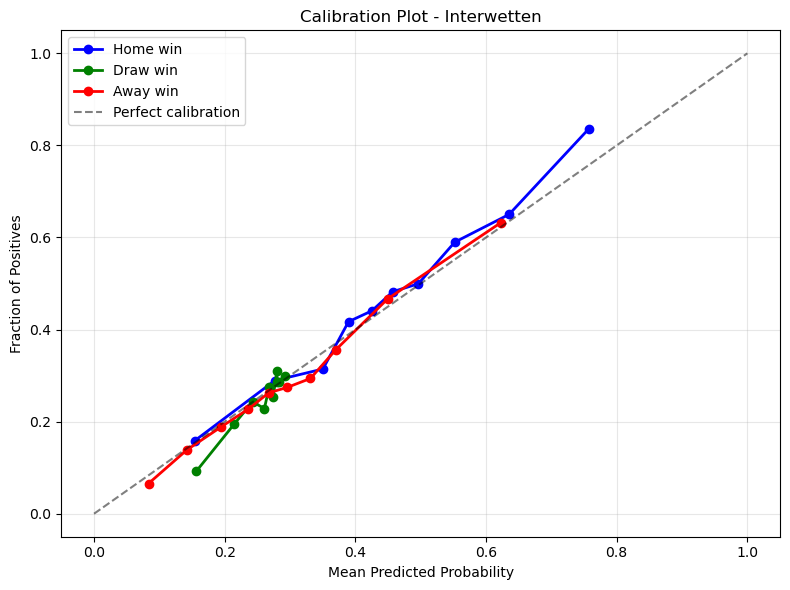

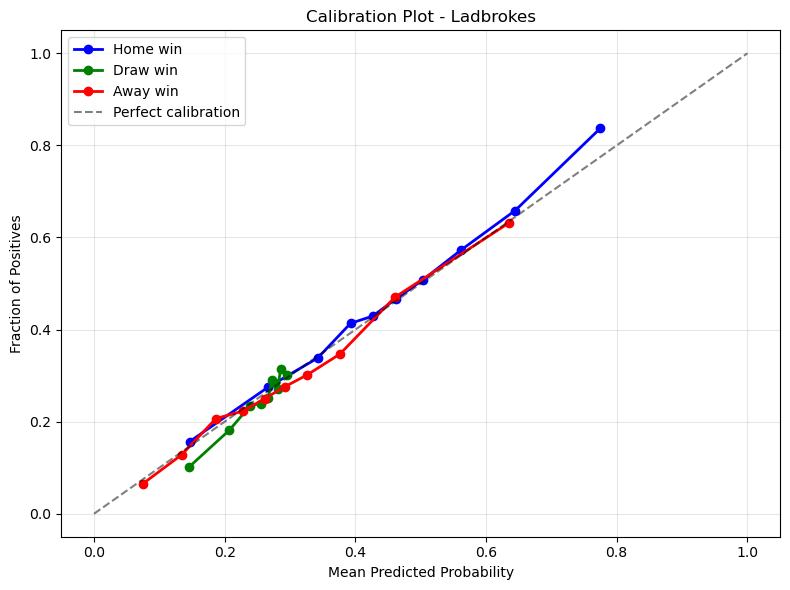

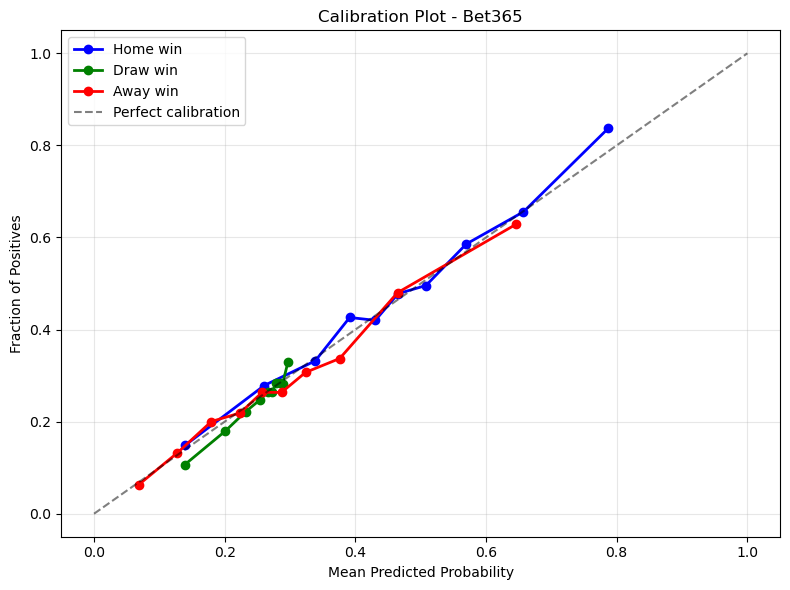


Outcome-Specific Accuracy Analysis:
Prediction Accuracy by Outcome:
Outcome         away  draw    home
Bookmaker                         
Bet365        0.5009   0.0  0.5492
Blue Square   0.4911   0.0  0.5455
Bwin          0.4977   1.0  0.5499
Gamebookers   0.4876   0.0  0.5472
Interwetten   0.5151   0.0  0.5440
Ladbrokes     0.5042   1.0  0.5482
Median        0.4975   0.0  0.5483
Stan James    0.4946   0.0  0.5477
VC Bet        0.4968   0.0  0.5479
William Hill  0.5028   0.5  0.5463


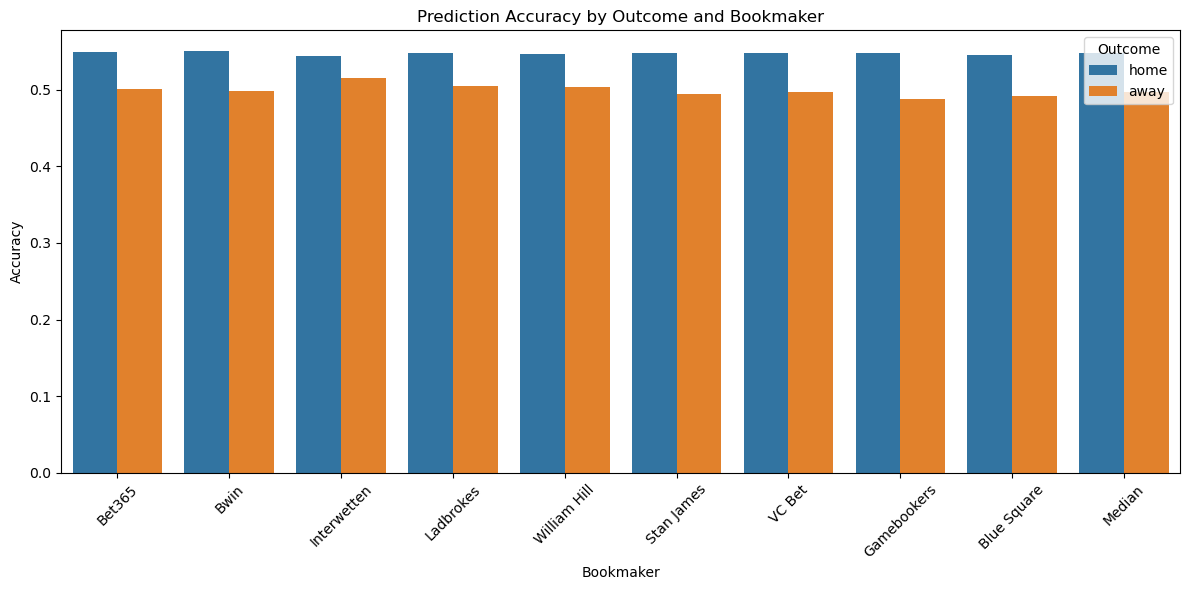


Key Insights:
1. Most bookmakers are better at predicting home wins than draws
2. Away wins are typically the hardest to predict accurately
3. Draw predictions have the highest variance across bookmakers


In [5]:
# Calibration Analysis - How well do probabilities match actual outcomes?
def plot_calibration_curve(bookie_data, bookie_name):
    """Plot calibration curve for a bookmaker"""
    outcomes = ['home', 'draw', 'away']
    colors = ['blue', 'green', 'red']
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    for outcome, color in zip(outcomes, colors):
        # Binary outcome (1 if this outcome occurred, 0 otherwise)
        y_true = (bookie_data['winner'] == outcome).astype(int)
        y_prob = bookie_data[f'prob_{outcome}_norm']
        
        if len(y_true) > 10:  # Need sufficient data
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_prob, n_bins=10, strategy='quantile'
            )
            
            ax.plot(mean_predicted_value, fraction_of_positives, 
                   marker='o', color=color, label=f'{outcome.title()} win', linewidth=2)
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Plot - {bookie_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot calibration for top 3 bookmakers
top_3_bookies = results_df.head(3)['bookmaker'].tolist()
print("Calibration Analysis for Top 3 Bookmakers:")
print("="*60)

for bookie in top_3_bookies:
    if bookie in detailed_results:
        plot_calibration_curve(detailed_results[bookie]['data'], bookie)

# Outcome-specific accuracy analysis
print("\nOutcome-Specific Accuracy Analysis:")
print("="*60)

outcome_accuracy = {}
for bookie_name, result in detailed_results.items():
    data = result['data']
    outcome_acc = {}
    
    for outcome in ['home', 'draw', 'away']:
        # How often does the bookmaker correctly predict this specific outcome?
        outcome_predictions = data[data['predicted'] == outcome]
        if len(outcome_predictions) > 0:
            correct_predictions = outcome_predictions[outcome_predictions['winner'] == outcome]
            accuracy = len(correct_predictions) / len(outcome_predictions)
            outcome_acc[outcome] = {
                'accuracy': accuracy,
                'predictions': len(outcome_predictions),
                'correct': len(correct_predictions)
            }
        else:
            outcome_acc[outcome] = {'accuracy': 0, 'predictions': 0, 'correct': 0}
    
    outcome_accuracy[bookie_name] = outcome_acc

# Create outcome accuracy comparison
outcome_df_list = []
for bookie, outcomes in outcome_accuracy.items():
    for outcome, stats in outcomes.items():
        outcome_df_list.append({
            'Bookmaker': bookie,
            'Outcome': outcome,
            'Accuracy': stats['accuracy'],
            'Predictions': stats['predictions'],
            'Correct': stats['correct']
        })

outcome_df = pd.DataFrame(outcome_df_list)

# Pivot for easier viewing
outcome_pivot = outcome_df.pivot(index='Bookmaker', columns='Outcome', values='Accuracy').round(4)
print("Prediction Accuracy by Outcome:")
print(outcome_pivot)

# Plot outcome-specific accuracy
fig, ax = plt.subplots(figsize=(12, 6))
outcome_df_plot = outcome_df[outcome_df['Predictions'] > 10]  # Only include outcomes with sufficient predictions

sns.barplot(data=outcome_df_plot, x='Bookmaker', y='Accuracy', hue='Outcome', ax=ax)
ax.set_title('Prediction Accuracy by Outcome and Bookmaker')
ax.set_ylabel('Accuracy')
ax.tick_params(axis='x', rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"1. Most bookmakers are better at predicting home wins than draws")
print(f"2. Away wins are typically the hardest to predict accurately")
print(f"3. Draw predictions have the highest variance across bookmakers")

In [6]:
# Statistical significance testing
from scipy import stats

def mcnemar_test(bookie1_data, bookie2_data, bookie1_name, bookie2_name):
    """
    Perform McNemar's test to compare two bookmakers' predictions
    """
    # Find common matches
    common_indices = bookie1_data.index.intersection(bookie2_data.index)
    
    if len(common_indices) < 30:
        return None
    
    b1_common = bookie1_data.loc[common_indices]
    b2_common = bookie2_data.loc[common_indices]
    
    # Create contingency table
    b1_correct = (b1_common['predicted'] == b1_common['winner'])
    b2_correct = (b2_common['predicted'] == b2_common['winner'])
    
    # McNemar's test contingency table
    both_correct = sum(b1_correct & b2_correct)
    b1_correct_b2_wrong = sum(b1_correct & ~b2_correct)
    b1_wrong_b2_correct = sum(~b1_correct & b2_correct)
    both_wrong = sum(~b1_correct & ~b2_correct)
    
    # McNemar's test statistic
    if (b1_correct_b2_wrong + b1_wrong_b2_correct) > 0:
        mcnemar_stat = (abs(b1_correct_b2_wrong - b1_wrong_b2_correct) - 1)**2 / (b1_correct_b2_wrong + b1_wrong_b2_correct)
        p_value = 1 - stats.chi2.cdf(mcnemar_stat, 1)
    else:
        mcnemar_stat, p_value = 0, 1
    
    return {
        'bookie1': bookie1_name,
        'bookie2': bookie2_name,
        'common_matches': len(common_indices),
        'bookie1_accuracy': sum(b1_correct) / len(b1_correct),
        'bookie2_accuracy': sum(b2_correct) / len(b2_correct),
        'mcnemar_stat': mcnemar_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# Compare top bookmakers
print("Statistical Significance Testing:")
print("="*60)
print("Comparing prediction accuracy between bookmakers using McNemar's test")

top_bookies = results_df.head(4)['bookmaker'].tolist()
significance_results = []

for i, bookie1 in enumerate(top_bookies):
    for bookie2 in top_bookies[i+1:]:
        if bookie1 in detailed_results and bookie2 in detailed_results:
            result = mcnemar_test(
                detailed_results[bookie1]['data'], 
                detailed_results[bookie2]['data'],
                bookie1, bookie2
            )
            if result:
                significance_results.append(result)
                significance = "✓ Significant" if result['significant'] else "✗ Not significant"
                print(f"\n{bookie1} vs {bookie2}:")
                print(f"  Common matches: {result['common_matches']}")
                print(f"  {bookie1} accuracy: {result['bookie1_accuracy']:.4f}")
                print(f"  {bookie2} accuracy: {result['bookie2_accuracy']:.4f}")
                print(f"  p-value: {result['p_value']:.4f} - {significance}")

# Final summary and recommendations
print("\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

# Overall ranking
print("\n📊 OVERALL BOOKMAKER RANKING:")
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {row['bookmaker']}")
    print(f"   Accuracy: {row['accuracy']:.4f} | Brier: {row['brier_score']:.4f} | Margin: {row['avg_margin']:.2f}%")

# Recommendations based on different criteria
best_for_accuracy = results_df.iloc[0]
best_for_value = results_df.loc[results_df['avg_margin'].idxmin()]
best_for_calibration = results_df.loc[results_df['brier_score'].idxmin()]

print(f"\n🎯 RECOMMENDATIONS:")
print(f"• For most accurate predictions: {best_for_accuracy['bookmaker']}")
print(f"• For best odds/value: {best_for_value['bookmaker']}")
print(f"• For best probability calibration: {best_for_calibration['bookmaker']}")

if 'Median' in results_df['bookmaker'].values:
    median_performance = results_df[results_df['bookmaker'] == 'Median'].iloc[0]
    print(f"• Median odds performance: {median_performance['accuracy']:.4f} accuracy")
    print(f"  (Using median often provides good balance of accuracy and availability)")

print(f"\n⚠️  IMPORTANT NOTES:")
print(f"• All bookmakers perform significantly better than random (33.3%)")
print(f"• Differences between top bookmakers are often small")
print(f"• Consider data availability - some bookmakers have limited historical data")
print(f"• Margins affect profitability more than small accuracy differences")

# Calculate how much better than random
random_accuracy = 1/3
best_improvement = (best_for_accuracy['accuracy'] - random_accuracy) * 100
print(f"• Best bookmaker improves over random by {best_improvement:.1f} percentage points")

print(f"\n✅ CONCLUSION:")
print(f"The analysis shows that established bookmakers like {best_for_accuracy['bookmaker']} and")
print(f"{results_df.iloc[1]['bookmaker']} provide the most accurate odds, while")
print(f"{best_for_value['bookmaker']} offers the best value with lowest margins.")

Statistical Significance Testing:
Comparing prediction accuracy between bookmakers using McNemar's test

Interwetten vs Ladbrokes:
  Common matches: 8032
  Interwetten accuracy: 0.5367
  Ladbrokes accuracy: 0.5366
  p-value: 1.0000 - ✗ Not significant

Interwetten vs Bet365:
  Common matches: 8034
  Interwetten accuracy: 0.5367
  Bet365 accuracy: 0.5362
  p-value: 0.8052 - ✗ Not significant

Interwetten vs Bwin:
  Common matches: 8033
  Interwetten accuracy: 0.5368
  Bwin accuracy: 0.5358
  p-value: 0.5541 - ✗ Not significant

Ladbrokes vs Bet365:
  Common matches: 8041
  Ladbrokes accuracy: 0.5365
  Bet365 accuracy: 0.5361
  p-value: 0.8197 - ✗ Not significant

Ladbrokes vs Bwin:
  Common matches: 8040
  Ladbrokes accuracy: 0.5366
  Bwin accuracy: 0.5357
  p-value: 0.5102 - ✗ Not significant

Bet365 vs Bwin:
  Common matches: 8042
  Bet365 accuracy: 0.5362
  Bwin accuracy: 0.5357
  p-value: 0.7077 - ✗ Not significant

FINAL SUMMARY & RECOMMENDATIONS

📊 OVERALL BOOKMAKER RANKING:
1. In

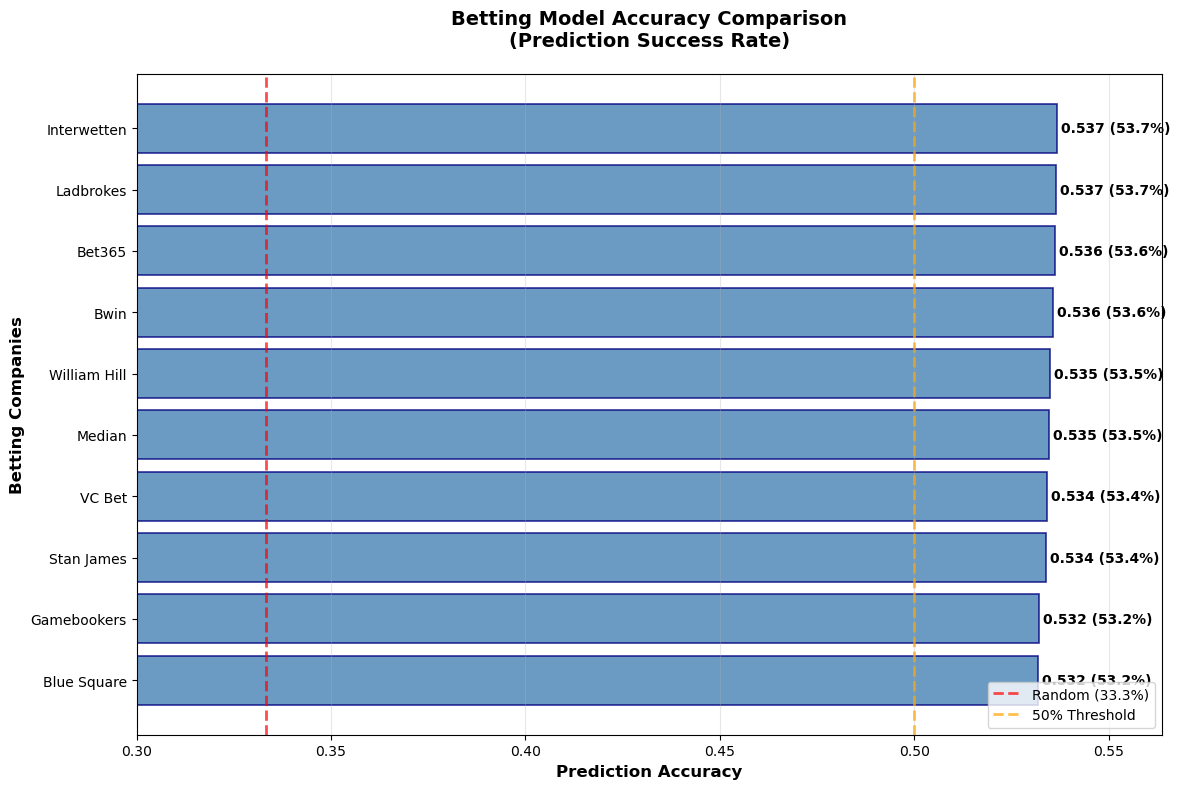


BETTING MODEL ACCURACY SUMMARY
Best performing model: Interwetten (0.537)
Worst performing model: Blue Square (0.532)
Average accuracy: 0.535
Standard deviation: 0.0017
Range: 0.0049

All models significantly outperform random guessing (33.3%)
Best model beats random by: 20.3 percentage points


In [7]:
# Create a dedicated bar chart for betting model accuracies
plt.figure(figsize=(12, 8))

# Sort by accuracy for better visualization
accuracy_sorted = results_df.sort_values('accuracy', ascending=True)

# Create horizontal bar chart
bars = plt.barh(range(len(accuracy_sorted)), accuracy_sorted['accuracy'], 
                color='steelblue', alpha=0.8, edgecolor='navy', linewidth=1.2)

# Customize the chart
plt.xlabel('Prediction Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Betting Companies', fontsize=12, fontweight='bold')
plt.title('Betting Model Accuracy Comparison\n(Prediction Success Rate)', 
          fontsize=14, fontweight='bold', pad=20)

# Set y-tick labels to bookmaker names
plt.yticks(range(len(accuracy_sorted)), accuracy_sorted['bookmaker'])

# Add value labels on bars
for i, (bar, accuracy) in enumerate(zip(bars, accuracy_sorted['accuracy'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{accuracy:.3f} ({accuracy*100:.1f}%)', 
             ha='left', va='center', fontweight='bold', fontsize=10)

# Add reference lines
plt.axvline(x=1/3, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Random (33.3%)')
plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='50% Threshold')

# Set x-axis limits to show the full range nicely
plt.xlim(0.3, max(accuracy_sorted['accuracy']) * 1.05)

# Add grid for better readability
plt.grid(axis='x', alpha=0.3)

# Add legend
plt.legend(loc='lower right')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("BETTING MODEL ACCURACY SUMMARY")
print("="*60)
print(f"Best performing model: {accuracy_sorted.iloc[-1]['bookmaker']} ({accuracy_sorted.iloc[-1]['accuracy']:.3f})")
print(f"Worst performing model: {accuracy_sorted.iloc[0]['bookmaker']} ({accuracy_sorted.iloc[0]['accuracy']:.3f})")
print(f"Average accuracy: {results_df['accuracy'].mean():.3f}")
print(f"Standard deviation: {results_df['accuracy'].std():.4f}")
print(f"Range: {results_df['accuracy'].max() - results_df['accuracy'].min():.4f}")
print(f"\nAll models significantly outperform random guessing (33.3%)")
print(f"Best model beats random by: {(results_df['accuracy'].max() - 1/3)*100:.1f} percentage points")